In [44]:
import pandas as pd
import numpy as np
import json
import seaborn as sns

In [45]:
with open('primed_qtable.json', 'r') as file:
    data = json.load(file)

In [46]:
data_df = pd.DataFrame(data)
data_df

,0,1,2,3,4,5,6
0,0.994820,0.540792,0.773019,0.596463,0.576441,0.227138,0.189058
1,0.444932,0.024852,0.279531,0.395338,0.753445,0.885888,0.029919
2,0.944578,0.188956,0.247432,0.727039,0.949219,0.559115,0.629609
3,0.187289,0.696495,0.879979,0.785547,0.208874,0.283221,0.172408
4,0.184117,0.579819,0.704828,0.562865,0.303311,0.144288,0.532843
...,...,...,...,...,...,...,...
495,0.179092,0.320190,0.489285,0.990251,0.852350,0.094614,0.490556
496,0.959366,0.619725,0.500022,0.493151,0.830163,0.445055,0.777461
497,0.760982,0.992201,0.502761,0.019981,0.788696,0.178986,0.571695
498,0.899483,0.642874,0.151927,0.193765,0.331240,0.129651,0.572591


<Axes: >

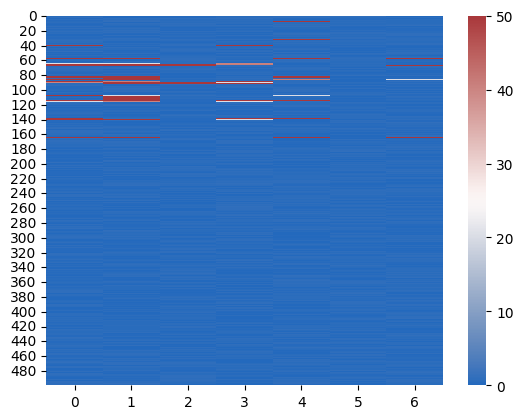

In [52]:
sns.color_palette("vlag", as_cmap=True)


sns.heatmap(data_df, vmax=50.0, vmin=0.0, cmap="vlag" )

In [ ]:
data_df

In [48]:
numpy_array = np.array(data)


In [49]:
print(numpy_array)

{'0': {'0': 0.9948197546, '1': 0.4449317207, '2': 0.9445775876, '3': 0.1872890561, '4': 0.184116659, '5': 0.6879580026, '6': 0.3679877718, '7': 0.4472985835, '8': 0.9223988473, '9': 0.6158347386, '10': 0.2895339322, '11': 0.0639560663, '12': 0.1364239965, '13': 0.2420270194, '14': 0.8419212846, '15': 0.2845659902, '16': 0.4219022703, '17': 0.906340641, '18': 0.2653916771, '19': 0.5294840812, '20': 0.4769703165, '21': 0.7816681818, '22': 0.4020870912, '23': 0.5903009451, '24': 0.7351146873, '25': 0.1807270918, '26': 0.0231400042, '27': 0.3314372863, '28': 0.4883227304, '29': 0.3009091353, '30': 0.260716908, '31': 0.2392389183, '32': 0.7368420136, '33': 0.9286256527, '34': 0.6731866521, '35': 0.3734606389, '36': 0.7633659299, '37': 0.3410017317, '38': 0.9215339216, '39': 0.395250698, '40': 660.1938774974, '41': 0.8836866253, '42': 0.7880239764, '43': 0.0602929501, '44': 0.6927893798, '45': 0.4012485203, '46': 0.7732946217, '47': 0.3689330983, '48': 0.9893708456, '49': 0.1908057138, '50':